In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflecting Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
Base.classes.keys()

['measurement', 'station']

In [8]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
session = Session(engine)

In [10]:
hawaii_info = pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_info.head()

,station,date,prcp,tobs
0,USC00519397,1/1/2010,0.08,65
1,USC00519397,1/2/2010,0.00,63
2,USC00519397,1/3/2010,0.00,74
3,USC00519397,1/4/2010,0.00,76
4,USC00519397,1/6/2010,NaN,73


In [11]:
hawaii = hawaii_info.dropna(how='any')
hawaii.head()

,station,date,prcp,tobs
0,USC00519397,1/1/2010,0.08,65
1,USC00519397,1/2/2010,0.00,63
2,USC00519397,1/3/2010,0.00,74
3,USC00519397,1/4/2010,0.00,76
5,USC00519397,1/7/2010,0.06,70


## Precipitation Analysis

In [72]:
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print (year_ago)

2016-08-23


In [73]:
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

Text(0, 0.5, 'Inches')

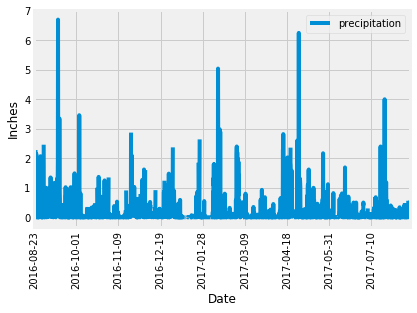

In [74]:
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'precipitation'])
prcp_df.set_index(prcp_df['date'], inplace=True)
prcp_df.index.name = None
prcp_df = prcp_df.sort_values("date")
prcp_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [75]:
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [76]:
# How many stations are available in this dataset?
session.query(Station.id).count()

9

In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

In [78]:
# Using the station id from the previous query, the script calculates the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
target = active[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station==target).all()

[(54.0, 85.0, 71.66378066378067)]

In [79]:
# Querying the last 12 months of temperature observation data for the station with the highest number.
# and plotting the results as a histogram
temp_obs = session.query(Measurement.tobs).\
    filter(Measurement.station==target).\
    filter(Measurement.date > '2016-08-23').all()
tobs_df = pd.DataFrame(temp_obs)
tobs_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


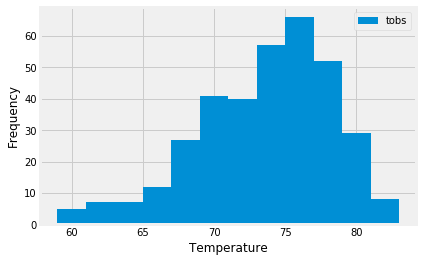

In [80]:
tobs_df.plot.hist(bins=12, grid=True)
plt.ylabel('Frequency')
plt.xlabel("Temperature")
plt.show()

## Temperature Analysis

In [82]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-07-01', '2017-07-08'))

[(71.0, 78.04347826086956, 87.0)]


In [83]:
# Using `calc_temps` to calculate the tmin, tavg, and tmax 
# for the trip using the previous year's data for the same dates.
import datetime as dt

prev_year_start = dt.date(2016, 7, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2016, 7, 8) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

68.0 77.71428571428571 83.0


/Users/jeremystewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


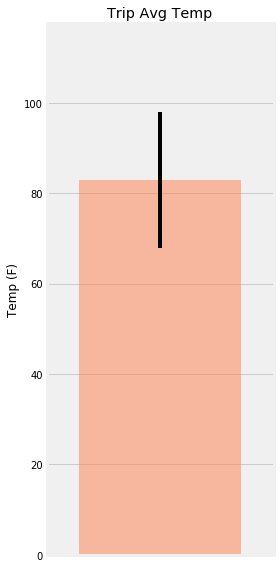

In [84]:
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [85]:
# Calculating the total amount of rainfall per weather station for my trip dates using the previous year's matching dates.
# Sorting this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_start = dt.date(2016, 7, 1)
prev_end = dt.date(2016, 7, 8)

prev_prcp = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp)).\
filter(Measurement.station==Station.station).filter(Measurement.date > prev_start, Measurement.date < prev_end).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

prev_prcp

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2.83),
 ('USC00519281', 'WAIHEE 837.5, HI US', 1.46),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.73),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.44000000000000006),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.39),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.09),
 ('USC00517948', 'PEARL CITY, HI US', None)]

## Daily Rainfall Average

In [86]:
# A query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("07-01")

[(67.0, 74.77777777777777, 81.0)]

In [87]:
# Calculating the daily normals for my trip
trip_start = '2020-07-01'
trip_end = '2020-07-08'

trip_dates = pd.date_range(trip_start, trip_end, freq='D')

trip_month_day = trip_dates.strftime('%m-%d')

normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0)]

In [88]:
# Loading the previous query results into a Pandas DataFrame and adding the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2020-07-01,67.0,74.777778,81.0
2020-07-02,68.0,75.403846,82.0
2020-07-03,68.0,75.320755,87.0
2020-07-04,70.0,76.571429,81.0
2020-07-05,66.0,75.000000,81.0


Text(14.435000000000002, 0.5, 'Temperature')

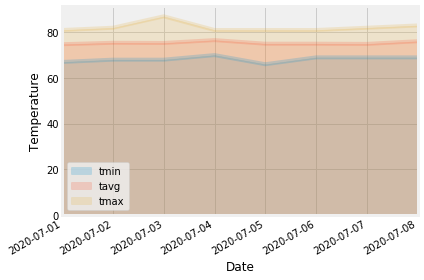

In [89]:
# Plotting the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")